<a href="https://colab.research.google.com/github/Krankile/npmf/blob/main/notebooks/fundamental_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
%%capture 
!pip install wandb

In [ ]:
%%capture
!git clone https://github.com/Krankile/npmf.git

In [ ]:
%%capture
!cd npmf && git pull
from npmf.utils.colors import main,main2,main3

In [ ]:
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm.notebook import tqdm

In [ ]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[main, main2, main3,"black"]) 

In [ ]:
with wandb.init(job_type='preprocessing', project="master-test") as run:

    artifact = run.use_artifact('oil-fundamental-data:latest')

    # Download the artifact's contents
    artifact_dir = artifact.download()

# Process fundamental data

## Start by defining $\mathcal{D}^{fun}_T$

In [ ]:
fundamental_df = pd.read_feather(artifact.file())
unique_companies = fundamental_df["Instrument"].unique().shape[0]
print(f"Unique companies in dataframe: {unique_companies}")

Unique companies in dataframe: 1988


In [ ]:
total_values = fundamental_df.count(axis=0, numeric_only=True).sum()
total_values

832729

$\mathcal{D}^{fun}_T$ = 832,729.  How ever, having this many quarterly datapoints surely contains some error — lets delve deeper! 

## Now we explore and clean the data

TODO remove data if balance sheet announcementdate is much later than quarterly rapport relevant date OR if its earlier

In [ ]:
#create margin coloumns 
for ticker in fundamental_df.columns[5:9]:

    fundamental_df[f"{ticker}p"] = fundamental_df[ticker] / fundamental_df["Total Revenue"]

In [ ]:
fundamental_df = fundamental_df.replace([np.inf, -np.inf], np.nan)

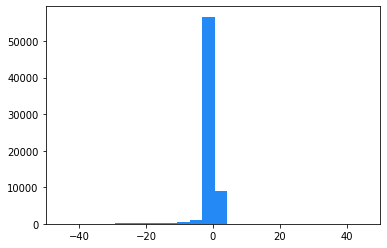

In [ ]:
plt.xlim(-50,50)
plt.hist(fundamental_df["EBITDAp"].dropna().values.flatten(), bins=30_000);

 ## Remove companies with weird data

Loop to explore where data is lost

In [ ]:
lost_companies_to_values_left = {}
ebitda_restriction_to_values_left = {}

for num in tqdm(np.linspace(100,0,1000)):
    weird_positive_df = fundamental_df[fundamental_df["EBITDAp"] >= num]
    weird_negative_df = fundamental_df[fundamental_df["EBITDAp"] <= -num -0.5]
    
        
    lost_companies = set(weird_positive_df["Instrument"].unique()) | set(weird_positive_df["Instrument"].unique())

    lost_companies_count = len(lost_companies)

    values_left = total_values - fundamental_df[fundamental_df["Instrument"].isin(list(lost_companies))].count(axis=0, numeric_only=True).sum()

    lost_companies_to_values_left[lost_companies_count] =  values_left
    ebitda_restriction_to_values_left[num] = values_left



  0%|          | 0/1000 [00:00<?, ?it/s]

 Visualise data

In [ ]:

xs = []
ys = []
for key in lost_companies_to_values_left:
    xs += [key]
    ys += [lost_companies_to_values_left[key]]

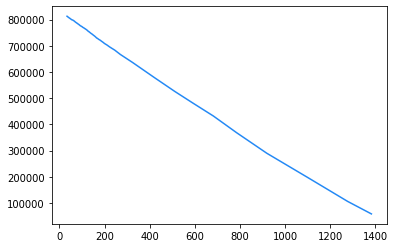

In [ ]:
plt.plot(xs,ys);

In [ ]:
xs1 = []
ys1 = []
for key in ebitda_restriction_to_values_left:
    xs1 += [key]
    ys1 += [ebitda_restriction_to_values_left[key]]

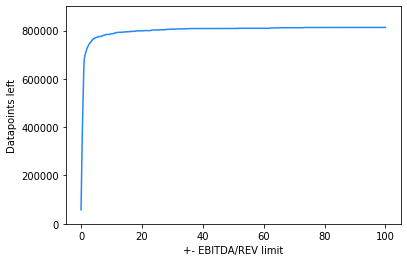

In [ ]:
plt.ylim(-1,900_000)
plt.ylabel("Datapoints left")
plt.xlabel("+- EBITDA/REV limit")
plt.plot(xs1,ys1);

Select a specific EBITDAp space and all companies with EBITDAp in that space

In [ ]:
weird_positive_df = fundamental_df[fundamental_df["EBITDAp"] >= 1]
weird_negative_df = fundamental_df[fundamental_df["EBITDAp"] <= -5]

    
lost_companies = set(weird_positive_df["Instrument"].unique()) | set(weird_positive_df["Instrument"].unique())

lost_companies_count = len(lost_companies)

values_left = total_values - fundamental_df[fundamental_df["Instrument"].isin(list(lost_companies))].count(axis=0, numeric_only=True).sum()


print(unique_companies - lost_companies_count)
values_left

1716


666569

In [ ]:
#get only valid companies (non bogus ebitdas)
cleaned_df = fundamental_df[fundamental_df["Instrument"].isin(set(fundamental_df["Instrument"].unique()) -  lost_companies)]

#remove all blank
cleaned_df = cleaned_df[cleaned_df["Balance Sheet Orig Announce Date"] != "" ]
cleaned_values = cleaned_df.count(axis=0, numeric_only=True).sum()
print(cleaned_values)
#remove all na
cleaned_df = cleaned_df[pd.to_datetime(cleaned_df['Balance Sheet Orig Announce Date'], errors='coerce').notnull()]
cleaned_df["Instrument"].dropna()

613084


1          OMVV.VI
3          OMVV.VI
4          OMVV.VI
5          OMVV.VI
6          OMVV.VI
           ...    
88073    ARACA.NFF
88074    ARACA.NFF
88075    ARACA.NFF
88076    ARACA.NFF
88077    ARACA.NFF
Name: Instrument, Length: 57603, dtype: string

In [ ]:
cleaned_values = cleaned_df.count(axis=0, numeric_only=True).sum()
cleaned_values

611123

See what values are lost when converting "balance sheet orig announce date"

In [ ]:
weird_after_cleaned = set(fundamental_df["Instrument"].unique()) -  lost_companies - set(cleaned_df["Instrument"].unique())
fundamental_df[fundamental_df["Instrument"].isin(weird_after_cleaned)]

# Add data with forward fill



In [ ]:
from matplotlib import axis
forward_filled_df = pd.DataFrame(columns=cleaned_df.columns) 

for ric in tqdm(cleaned_df["Instrument"].unique()):
    forward_filled_df = pd.concat( [forward_filled_df, cleaned_df[cleaned_df["Instrument"] == ric].ffill(axis = 0)], axis=0)

  0%|          | 0/1293 [00:00<?, ?it/s]

In [ ]:
forward_filled_df

In [ ]:
filename = 'fundamental-data-clean.feather'

forward_filled_df.reset_index().to_feather(filename)

In [ ]:
upload = True


if upload:
    with wandb.init(job_type='preprocessing', project="master-test") as run:
        artifact = wandb.Artifact(filename.split('.')[0], type='dataset')

        # Add a file to the artifact's contents
        artifact.add_file(filename)

        # Save the artifact version to W&B and mark it as the output of this run
        run.log_artifact(artifact)